# Dosimetría fotográfica
---------
El objeto de este cuaderno es procesar películas radiocrómicas EBT3 leídas con un escáner de sobremesa obtener mapas de dosis absorbida analizables mediante Portal Dosimetry (Varian). 

Las entradas del cuaderno son el plano de dosis exportado desde el planificador en formato `dcm` (DICOM RT) y la imagen digitalizada en fomato TIFF (color 48 bits). Para funcionar el cuaderno también necesita un archivo de configuración con datos sobre el escáner, las condiciones de calibración, de digitalización y de corrección tanto del ruido como del efecto lateral. 

Las salidas del cuaderno son el plano de dosis exportado desde el planificador convertido a formato `dxf` y el plano de dosis medido con la película también en `dxf`. El formato `dxf` es un tipo de archivo definido por Varian para el intercambio de datos. Se trata de archivos de texto del tipo valores separados por comas (`csv`) y un encabezado con metainformación de la medida. Ambos archivos se pueden importar en Portal Dosimetry para su análisis y comparación.

El procesado de las películas sigue un esquema de digitalización única (SSP, *single scan protocol*) en el que la película se lee en la misma digitalización en la que se calibra el escáner. Si la película de calibración se ha irradido en la misma sesión que la película a medir, el procedimiento es independiente del tiempo de evolución de la película, evitando tener que esperar el tiempo de estabilización. El procesado utiliza un análisis multicanal mediante promedios no locales. La calibración se realiza mediante un modelo sensitométrico de crecimiento con la dosis de dos fases del polímero, que es estable en el tiempo para un modelo de escáner y película dados. Las condiciones particulares del lote de fabricación de la película, fondo y estado del escáner se establecen durante la digitalización. El algoritmo también corrige por el efecto lateral. Este procedimiento permite obtener dosis que es directamente trazable a patrones de calibración.

## Procedimiento

- Elminación en su caso de artefacto lineales de digitalización
- Convertir el plano de dosis calculado en el planificador de formato DICOM a `dxf`
- Segmentar en la imagen digitalizada las regiones relevantes para aplicar el SSP
- Determinar la dosis en la película
- Reorientar el plano de dosis medido para hacerlo coincidir con la orientación del plano de dosis calculado
- Exportar la distribución espacial de dosis medida en formato `dxf`

Para aplicar este procedimiento seguir en orden secuencial las celdas del cuaderno.

## Código
-----------------
Importación de funciones 


In [1]:
%matplotlib widget
from ipyfilmqa import leerConfiguracion, exportarPlanoDosisPlanificador
from ipyfilmqa import representarPlanoDosisPlanificador, representarOrientacionesPlanoDosisPelicula
from ipyfilmqa import subirImagenDigitalizada, segmentarImagen, procesarPelicula
from ipyfilmqa import reorientarYExportarPlanoDosisPelicula

Leer la configuración del módulo de dosimetría fotográfica

In [2]:
leerConfiguracion()

Convertir el plano de dosis calculado en el planificador de formato DICOM a `dxf`

In [3]:
exportarPlanoDosisPlanificador()

FileUpload(value={}, accept='.dcm, .DCM', description='Upload')

Output()

Subir al servidor la imagen digitalizada que contiene la película irradiada, la película de calibración y la película sin irradiar

In [4]:
subirImagenDigitalizada()

FileUpload(value={}, accept='.tif, .tiff', description='Upload')

Output()

Etiquetar en la imagen las regiones con la dosis medida, el recorte de calibración, el fondo y la indicación del centro del digitalizador en la dirección de la lámpara. Una vez etiquetada no olvidar pulsar el botón **Submit**

In [5]:
segmentarImagen()

BBoxWidget(classes=['Film', 'Calibration', 'Background', 'Center'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '…

Convertir en dosis la lectura de la película

In [6]:
%%capture --no-stdout --no-display

procesarPelicula()

Determinación de las coordenadas para la corrección lateral...
Determinación del fondo...
Calibración de la digitalización...
Dose preprocessing...
Dose calculation:


  0%|          | 0/456 [00:00<?, ?it/s]

La irradiación de la película puede realizarse orientándola de cualquier modo, pero la digitalización siempre se tiene que hacer respetando la orientación en la fue calibrada. En nuestro protocolo hemos decidido que sea en orientación *portrait*. De acuerdo a nuestros protocolos de corte siempre se marca la esquina superior derecha de cada recorte con un guión paralelo a la dirección estrecha de la película sin cortar. La lectura de la película se tiene que hacer colocándola en la bandeja del escáner con el guión paralelo a la lámpara del escáner.

La siguiente función permite reorientar la imagen en dosis para hacerla coincidir con el plano de dosis calculado en el planificador y después exporta el plano de dosis calculado en formato `dxf`.

In [ ]:
reorientarYExportarPlanoDosisPelicula()

## Documentación
---------

### Preparación de la película para la medida
### Preparación de la película de calibración
### Irradiación
#### Control de calidad del plan de un paciente
#### Calibración
### Digitgalización
### Procesado

In [8]:
from ipyfilmqa import st

In [2]:
from skimage.io import imread
from skimage import img_as_ubyte
from skimage.exposure import rescale_intensity
from skimage import img_as_float64, img_as_uint
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [3]:
im = imread('ps+1-1.tif')

In [6]:
imf=img_as_float64(im)
imfo=img_as_float64(im)
imf[:, 152, :] = imf[:, 152, :] * .91
imf[:, 145, :] = imf[:, 145, :] * .95
imf[imfo[...]>0.9]=imfo[imfo[...]>0.9]
imf[imf[...]>1]=1
imc = img_as_uint(imf)

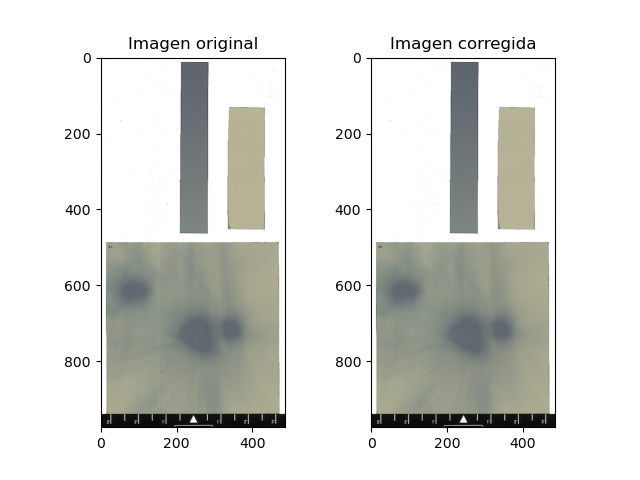

In [7]:
fig, (axo, axc) = plt.subplots(ncols=2)
imub = img_as_ubyte(rescale_intensity(im, out_range='uint8'))
imcub = img_as_ubyte(rescale_intensity(imc, out_range='uint8'))
axo.set_title('Imagen original')
axc.set_title('Imagen corregida')
axo.imshow(imub)
axc.imshow(imcub)
plt.show()

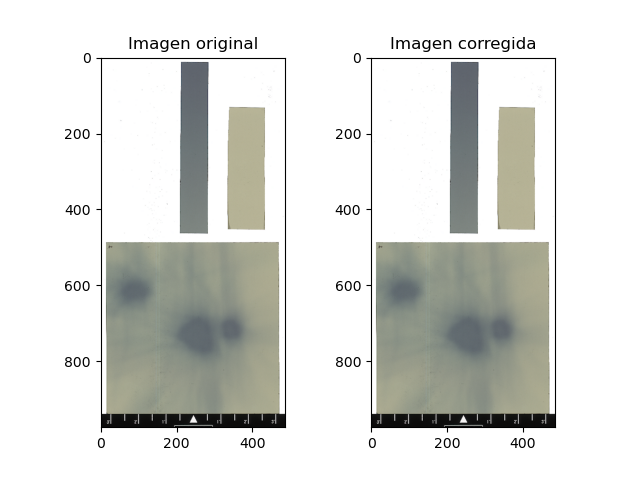

interactive(children=(IntSlider(value=200, description='px', max=486), FloatSlider(value=1.0, description='fc'…

In [10]:
h, w, ch = im.shape

fig, (axo, axc) = plt.subplots(ncols=2)
imc = im.copy()
imub = img_as_ubyte(rescale_intensity(im, out_range='uint8'))
imcub = img_as_ubyte(rescale_intensity(imc, out_range='uint8'))
axo.set_title('Imagen original')
axc.set_title('Imagen corregida')
axo.imshow(imub)
axc.imshow(imcub)
plt.show()

def my_im(im, p, f):
    """
    Corrects the scan calibration artifacts
    """
    imf=img_as_float64(im)
    imfo=img_as_float64(im)
    
    imf[:, p, :] = imf[:, p, :] * f
    
    imf[imfo[...]>0.9]=imfo[imfo[...]>0.9]
    imf[imf[...]>1]=1
    imc = img_as_uint(imf)
    return imc
 
 
@widgets.interact(px=(0, w, 1), fc=(0.8, 1, .01))
def update(px=200, fc=1.):
    """
    Update the corrected imaage axis
    """
    global imc
    imc = my_im(im=imc, p=px, f=fc)
    imcub = img_as_ubyte(rescale_intensity(imc, out_range='uint8'))
    axc.imshow(imcub)

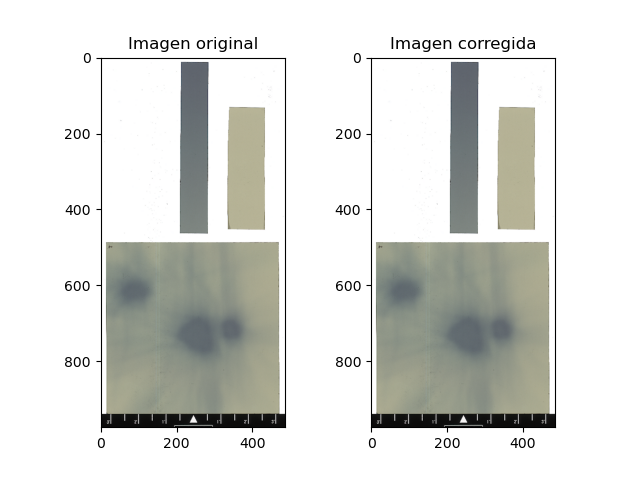

In [13]:
pixels = widgets.Text(
    value='',
    placeholder='Secuencia ej: 150, 145',
    description='Pixels:',
    disabled=False
)
factors = widgets.Text(
    value='',
    placeholder='Secuencia ej: 0.91, 0.95',
    description='Factores:',
    disabled=False
)

correct = widgets.Button(
    description='Corregir'
)

salida = widgets.Output()

h, w, ch = im.shape

fig, (axo, axc) = plt.subplots(ncols=2)
imc = im.copy()
imub = img_as_ubyte(rescale_intensity(im, out_range='uint8'))
imcub = img_as_ubyte(rescale_intensity(im, out_range='uint8'))
axo.set_title('Imagen original')
axc.set_title('Imagen corregida')
axo.imshow(imub)
axc.imshow(imcub)

def my_im(im, ps, fs):
    """
    Corrects the scan calibration artifacts
    """
    imf=img_as_float64(im)
    imfo=img_as_float64(im)
    
    for p, f in zip(ps, fs):
        imf[:, p, :] = imf[:, p, :] * f
    
    imf[imfo[...]>0.9]=imfo[imfo[...]>0.9]
    imf[imf[...]>1]=1
    imc = img_as_uint(imf)
    return imc


def on_clicked_correct(b):
    ps = list(map(int, pixels.value.split(',')))
    fs = list(map(float, factors.value.split(',')))
    global imc
    imc = my_im(imc, ps, fs)
    imcub = img_as_ubyte(rescale_intensity(imc, out_range='uint8'))
    axc.imshow(imcub)    

correct.on_click(on_clicked_correct)

widgets.VBox([pixels, factors, correct, salida])

In [11]:
    with salida:
        print('Valores seleccionados:')
        print(list(map(int, pixels.value.split(','))))
        print(list(map(float, factors.value.split(','))))


[1.0, 2.0]